In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import dataframe_image as dfi

In [15]:
"""
Loads in raw score file
Expecting the schema 
Name	Date	GF	GA	Team

Calcuates result, margies and goal difference
Does some prep work for Form and Win

Obviously names need to be consistant
"""
season = "S3_results"

raw_data = pd.read_csv("../data/"+season+".csv")
raw_data["GD"] = raw_data["GF"] - raw_data["GA"]
raw_data.loc[(raw_data['GD'] == 0), 'GamePoints'] = 0.5
raw_data.loc[(raw_data['GD'] < 0), 'GamePoints'] = -1
raw_data.loc[(raw_data['GD'] > 0), 'GamePoints'] = 1
raw_data.loc[(raw_data['GD'] > 6), 'GamePoints'] = 1.5
raw_data.loc[(raw_data['GD'] < -6), 'GamePoints'] = -1.5
raw_data.loc[(raw_data['GamePoints'] >= 1), 'W'] = 1
raw_data.loc[(raw_data['GamePoints'] == 0.5), 'D'] = 1
raw_data.loc[(raw_data['GamePoints'] <= -1), 'L'] = 1
raw_data.loc[(raw_data['GamePoints'] == 1.5), 'MW'] = 1
raw_data.loc[(raw_data['GamePoints'] == -1.5), 'ML'] = 1

raw_data.loc[(raw_data['GamePoints'] >= 1), 'Result'] = '🔼'
raw_data.loc[(raw_data['GamePoints'] == 0.5), 'Result'] = '➖'
raw_data.loc[(raw_data['GamePoints'] <= -1), 'Result'] = '🔽'
raw_data.loc[(raw_data['GamePoints'] == 1.5), 'Result'] = '⏫'
raw_data.loc[(raw_data['GamePoints'] == -1.5), 'Result'] = '⏬'

raw_data = raw_data[raw_data["Name"].str.contains("\*")==False] # Removes Ringers

raw_data = raw_data.fillna(0)
pd.set_option('display.float_format', '{:.1f}'.format)
raw_data = raw_data.astype({'W':'int','D':'int','L':'int','MW':'int','ML':'int','GF':'int','GA':'int','GD':'int'})

raw_data['Date'] = pd.to_datetime(raw_data['Date'],dayfirst = True)
gameweek_int = raw_data.nunique().Date
gameweek = "Gameweek " + str(gameweek_int)

dates = pd.DataFrame(raw_data.sort_values("Date").Date.unique(),columns=['Date'])
dates['Gameweek'] = dates.index+1

raw_data = raw_data.merge(dates,how='right',on='Date')

pd.set_option('display.max_rows', 50)

display(raw_data)

,Name,Date,GF,GA,Team,GD,GamePoints,W,D,L,MW,ML,Result,Gameweek
0,Noel,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
1,Helmet,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
2,Gupta,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
3,Tristan,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
4,Einstein,2024-08-15,15,26,BLANCOS,-11,-1.5,0,0,1,0,1,⏬,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Wilf,2024-09-26,16,18,BLANCOS,-2,-1.0,0,0,1,0,0,🔽,7
62,Zola,2024-09-26,16,18,BLANCOS,-2,-1.0,0,0,1,0,0,🔽,7
63,Tristan,2024-09-26,16,18,BLANCOS,-2,-1.0,0,0,1,0,0,🔽,7
64,Helmet,2024-09-26,16,18,BLANCOS,-2,-1.0,0,0,1,0,0,🔽,7


In [16]:
"""
Creates the Form Column
"""
def form_column(raw_data):
    raw_data['game_rank'] = raw_data.sort_values("Date").groupby("Name").Date.rank(ascending=False)
    raw_data_form = raw_data.loc[raw_data['game_rank'] <= 5]
    form = raw_data_form.groupby(['Name'], as_index=False).agg({'Result': ' '.join})
    return form

form = form_column(raw_data)

#display(form)

In [17]:
"""
Creates Matches Played (MP), Partipation (Par%), Pts and Win% (W%)

It also aggreates all the raw data to create an up to date table
"""
def get_totals(raw_data):
    played = raw_data.groupby('Name').count()
    played = pd.DataFrame(played["Date"]).rename(columns={"Date":"MP"})
    data = raw_data.groupby('Name').sum(numeric_only=True).sort_values(by=['GamePoints'],ascending=False).join(played).rename(columns={"GamePoints":"Pts"})

    data["Par%"] = data["MP"].div(gameweek_int)*100
    data["W%"] = data["W"]/data["MP"]*100
    
    data = data.astype({'Par%':'int','W%':'int'})
    data = data.sort_values(by=['Pts','W%'],ascending=False)
    return data

totals = get_totals(raw_data)



#display(totals)


In [18]:
"""
Join tables 
Drops unwanted columns 
Puts columns in the correct order
"""
table = totals.merge(form,on='Name').rename(columns={"Result":"Form"})
table.index = table.Name
table = table[['MP', 'W', 'D', 'L','MW', 'ML', 'GF', 'GA','GD','Par%','W%','Pts','Form']]
table.index.names = [gameweek]
table.dfi.export('../outputs/table.png')
table#.sort_values(by=['MP'],ascending=False)

,MP,W,D,L,MW,ML,GF,GA,GD,Par%,W%,Pts,Form
Gameweek 7,,,,,,,,,,,,,
Noel,5,4,0,1,1,0,97,80,17,71,80,3.5,⏫ 🔼 🔼 🔼 🔽
Einstein,7,5,0,2,0,1,120,119,1,100,71,2.5,🔼 🔼 🔽 🔼 🔼
Gilet,4,3,0,1,0,0,68,60,8,57,75,2.0,🔽 🔼 🔼 🔼
Wilf,4,3,0,1,0,0,71,63,8,57,75,2.0,🔼 🔼 🔼 🔽
Tristan,3,2,0,1,1,0,61,51,10,42,66,1.5,⏫ 🔼 🔽
Gupta,5,3,0,2,1,0,90,84,6,71,60,1.5,⏫ 🔼 🔽 🔼 🔽
Helmet,5,3,0,2,1,0,98,82,16,71,60,1.5,⏫ 🔽 🔼 🔼 🔽
Keysey,1,1,0,0,0,0,17,14,3,14,100,1.0,🔼
John,3,2,0,1,0,0,50,48,2,42,66,1.0,🔽 🔼 🔼


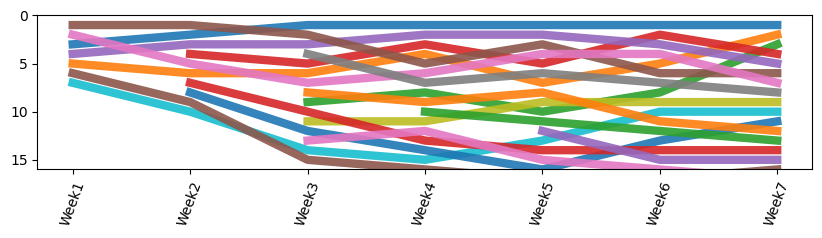

In [19]:
"""
Tracking week by week table position

"""
def get_gameweek(raw_data, Gameweek):

    gameweek_data = raw_data.loc[(raw_data['Gameweek']<=(Gameweek))].reset_index(drop=True)
    gameweek_data = get_totals(gameweek_data)
    table = gameweek_data.merge(form,on='Name').rename(columns={"Result":"Form"})
    gameweek_column_name = "Week" +str(Gameweek)
    table[gameweek_column_name] = table.index + 1
    table.index = table.Name
    table = table[[gameweek_column_name]]
    return table

def plot_save_bumpchart(raw_data):

    ranked = get_gameweek(raw_data,1)

    for week in range(raw_data['Date'].nunique()-1):
        week = week+2
        ranked = ranked.merge(get_gameweek(raw_data,week),how='right',on='Name')
    ranked.to_csv("../outputs/bumpchart.csv")
    ranked.T.to_csv("../outputs/bumpchart_t.csv")

    plt.figure(figsize=(10,2))
    plt.plot(ranked.T, alpha=0.9, linewidth=6)
    plt.xticks(rotation=70)
    plt.ylim(16, 0)
    #plt.gca().invert_xaxis()
    #plt.xticks(rotation=70)    

    plt.gca().invert_xaxis()
    plt.gca().invert_xaxis()
    plt.show()
    return(ranked)
ranked = plot_save_bumpchart(raw_data)

#https://public.flourish.studio/visualisation/15712793/

In [20]:
"""
Code from Github that creates a bumpchart 
""" 

def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

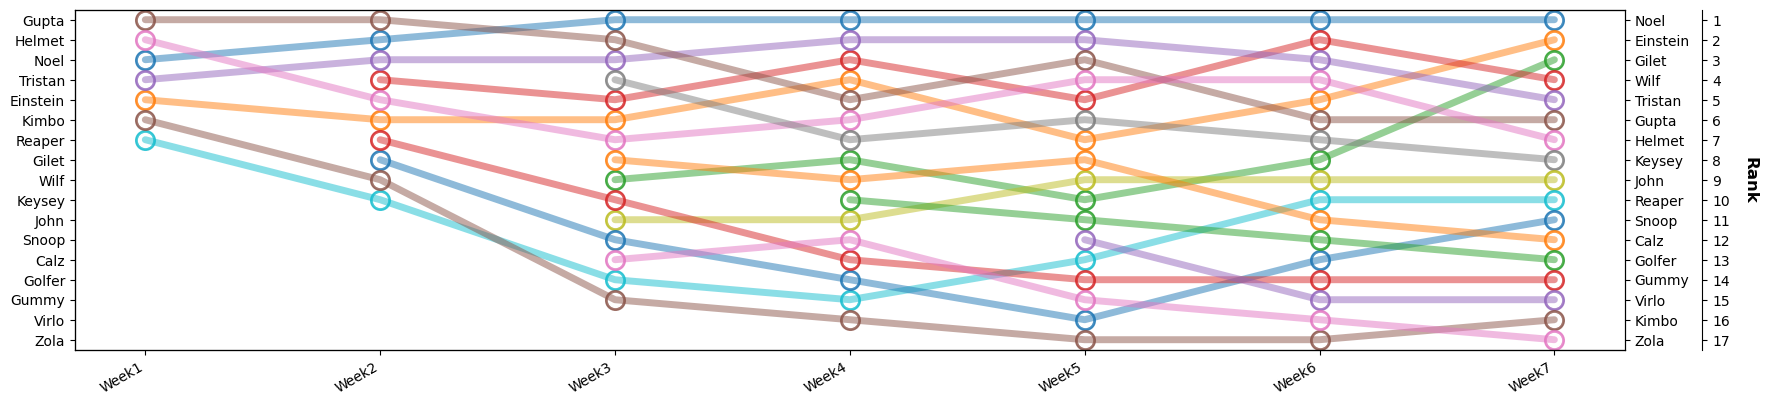

In [21]:
def bumpchart_external(ranked):

    plt.figure(figsize=(20, 5))

    [laxis, raxis, fraxis] = bumpchart(
                               ranked.T, show_rank_axis= True, 
                               rank_axis_distance= 1.05,
                               ax= None, 
                               scatter= True, 
                               holes= True,
                               line_args= {"linewidth": 5, "alpha": 0.5},
                               scatter_args= {"s": 200, "alpha": 0.8},
                               hole_args= {"s": 100, "alpha": 1})



    laxis.set_axisbelow(True)

    fraxis.set_ylabel("Rank", rotation= -90, labelpad= 20, fontsize= 12, weight= "semibold")\

    plt.gcf().autofmt_xdate()

    plt.show()
    
bumpchart_external(ranked)

In [22]:
teams = raw_data.groupby(['Date','Team','Result'])['Name'].apply(','.join).reset_index()
teams[['Player1','Player2','Player3','Player4','Player5']] = teams['Name'].str.split(',',expand=True)
teams = teams.drop('Name',axis=1)
print(teams)

         Date     Team Result   Player1  Player2   Player3   Player4 Player5
0  2024-08-15  BLANCOS      ⏬  Einstein    Kimbo    Reaper      None    None
1  2024-08-15    DARKS      ⏫      Noel   Helmet     Gupta   Tristan    None
2  2024-08-22  BLANCOS      🔽    Helmet   Reaper     Kimbo     Gummy   Snoop
3  2024-08-22    DARKS      🔼  Einstein  Tristan      Wilf     Gupta    Noel
4  2024-08-29  BLANCOS      🔼      Noel   Reaper  Einstein    Keysey    None
5  2024-08-29    DARKS      🔽      Zola    Kimbo     Gilet      John    Calz
6  2024-09-05  BLANCOS      🔽    Golfer   Reaper     Gupta     Gummy   Snoop
7  2024-09-05    DARKS      🔼    Helmet    Gilet      Wilf  Einstein    Noel
8  2024-09-12  BLANCOS      🔼      Calz    Gupta    Helmet      John  Reaper
9  2024-09-12    DARKS      🔽  Einstein    Virlo      Zola      Noel   Snoop
10 2024-09-19  BLANCOS      🔽      Calz    Gupta     Virlo     Kimbo    Zola
11 2024-09-19    DARKS      🔼  Einstein     Wilf     Gilet    Reaper   Snoop

In [23]:

df = teams
pair_counts = {}

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    players = row[['Player1', 'Player2', 'Player3', 'Player4', 'Player5']].tolist()

    # Generate unique pairs of players
    player_pairs = [(p1, p2) for p1 in players for p2 in players if p1 != p2]

    for pair in player_pairs:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1

# Create a new DataFrame from the pair counts
pair_counts_df = pd.DataFrame({'Player Pair': list(pair_counts.keys()), 'Count': list(pair_counts.values())})

# Display the resulting DataFrame
pair_counts_df.sort_values("Count", ascending=False)

,Player Pair,Count
62,"(Noel, Einstein)",4
53,"(Einstein, Noel)",4
113,"(Gilet, Einstein)",3
51,"(Einstein, Wilf)",3
56,"(Wilf, Einstein)",3
...,...,...
85,"(Gilet, Calz)",1
82,"(Gilet, Zola)",1
76,"(Zola, John)",1
75,"(Zola, Gilet)",1


In [24]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# If not, load your data into a DataFrame first

# Create an empty dictionary to store the pair-result counts
pair_result_counts = {}
df = teams
# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    players = row[['Player1', 'Player2', 'Player3', 'Player4', 'Player5']].tolist()

    # Generate unique pairs of players
    player_pairs = [(p1, p2) for p1 in players for p2 in players if p1 != p2]

    for pair in player_pairs:
        if pair in pair_result_counts:
            result = row['Result']
            pair_result_counts[pair][result] = pair_result_counts[pair].get(result, 0) + 1
        else:
            result = row['Result']
            pair_result_counts[pair] = {result: 1}

# Create a new DataFrame from the pair-result counts
pair_result_counts_df = pd.DataFrame(pair_result_counts).fillna(0)

# Display the resulting DataFrame
pair_result_counts_df
transposed_df = pair_result_counts_df.T
transposed_df_cleaned = transposed_df.dropna(axis=0).sort_index(axis=0)
transposed_df_cleaned

⏬   🔼   🔽   ⏫
Calz Gilet   0.0 0.0 1.0 0.0
     Gupta   0.0 1.0 1.0 0.0
     Helmet  0.0 1.0 0.0 0.0
     John    0.0 1.0 1.0 0.0
     Kimbo   0.0 0.0 2.0 0.0
...           ..  ..  ..  ..
NaN  Keysey  0.0 1.0 0.0 0.0
     Kimbo   2.0 0.0 0.0 0.0
     Noel    0.0 1.0 0.0 1.0
     Reaper  2.0 1.0 0.0 0.0
     Tristan 0.0 0.0 0.0 1.0

[184 rows x 4 columns]

In [25]:
margie = raw_data[["Date","GD"]]
margie['GD'] = margie['GD'].abs()
margie = margie.drop_duplicates().reset_index(drop=True)
margie['Margie'] = margie.GD.map( lambda x: True if x > 6 else False)
margie

C:\Users\EdmondMitchell\AppData\Local\Temp\ipykernel_2352\171748863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margie['GD'] = margie['GD'].abs()


,Date,GD,Margie
0,2024-08-15,11,True
1,2024-08-22,1,False
2,2024-08-29,3,False
3,2024-09-05,5,False
4,2024-09-12,3,False
5,2024-09-19,4,False
6,2024-09-26,2,False


In [26]:
from datetime import datetime, timedelta

# Starting date
start_date = datetime.now()

# Number of times to repeat the process
iterations = 30

# Loop to run 30 times
for i in range(iterations):
    # Print the current date 10 times
    for j in range(10):
        print(start_date.strftime("%d/%m/%Y"))
    # Increment the date by 7 days
    start_date += timedelta(days=7)

01/10/2024
01/10/2024
01/10/2024
01/10/2024
01/10/2024
01/10/2024
01/10/2024
01/10/2024
01/10/2024
01/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
08/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
15/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
22/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
29/10/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
05/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
12/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
19/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
26/11/2024
03/12/2024